In [1]:
# standard python data science stuff
import numpy as np
import pandas as pd
from scipy import sparse 
np.random.seed(123)  # for reproducibility



# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

# rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdmolops

# keras
from keras.models import Sequential  # a "left-to-right" sequence of layers in our NN
from keras.layers import Dense, Dropout, Activation, Flatten  # the types of layers we can have in a "regular" model
from keras.layers import Convolution2D, MaxPooling2D  # CNN type layers 
from keras.utils import np_utils
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
# get compounds

flu = Chem.MolFromSmiles('Fc1ccc(c(F)c1)C(O)(Cn2ncnc2)Cn3ncnc3')

In [3]:
def mol_to_morgan_matrix(mol, num_bits=128, max_radius=5):
    """
    Converts the atoms of an rdkit Mol object to a matrix with atoms and Morgan fp contributions.
    :param mol:          rdkit Mol object   the input molecule
    :param num_bits:     int                number of bits in Morgan fingerprint
    :return atom_fp_mat: ndarray            matrix of integers with shape (num_atoms, num_bits)
    """
    # basic info
    num_atoms = mol.GetNumAtoms()
    
    # get the Morgan fingerprint and each's atoms contribution to it
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 
                                               max_radius, 
                                               nBits = num_bits,
                                               bitInfo = info)
    
    atoms = []
    bits = []
    radii = []

    for k, v in info.items():
        these_atoms = [idx for (idx, _) in v]
        these_radii = [idx for (_, idx) in v]
        these_bits = [k] * len(these_atoms)
        atoms.extend(these_atoms)
        bits.extend(these_bits)
        radii.extend(these_radii)
        
    # form output matrix
    out = sparse.coo_matrix((radii, (atoms, bits)), 
                            shape=(num_atoms, num_bits),
                            dtype=np.int8)

    return(out.todense())

In [4]:
def mol_to_fp_matrix(mol, num_bits=128):
    """
    Converts the atoms of an rdkit Mol object to a matrix with atoms and Morgan fp contributions.
    :param mol:          rdkit Mol object   the input molecule
    :param num_bits:     int                number of bits in Morgan fingerprint
    :return atom_fp_mat: ndarray            matrix of integers with shape (num_atoms, num_bits)
    """
    # basic info
    num_atoms = mol.GetNumAtoms()
    
    # get molecule fingerprint
    by_atom = []
    _ = rdmolops.RDKFingerprint(mol,
                                fpSize=num_bits,
                                atomBits = by_atom)
    
    # instantiate output matrix
    fp_mat = np.zeros((num_atoms, num_bits), dtype=np.int8)
    
    # fill the values
    for row_idx, col_idx in enumerate(by_atom):
        fp_mat[row_idx, col_idx] = 1

    return(fp_mat)

In [5]:
X_train = mol_to_fp_matrix(Chem.AddHs(flu), num_bits=256)
Y_train = np.asarray([x for (x, y) in rdMolDescriptors._CalcCrippenContribs(Chem.AddHs(flu))])

my_shape = X_train.shape
model = Sequential()
model.add(Dense(output_dim=16,
                input_dim = my_shape[1],
                activation = 'sigmoid'))
model.add(Dense(output_dim=8,
                activation = 'relu'))
model.add(Dense(output_dim=1,
                activation = 'tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')


In [6]:
hist = model.fit(X_train, 
                  Y_train, 
                  batch_size=128,  
                  nb_epoch=500,
                  verbose=0,
                  #callbacks=[TQDMNotebookCallback(leave_inner=False)],
                )

In [7]:
predictions = model.predict(mol_to_fp_matrix(Chem.AddHs(flu), num_bits=256))

In [8]:
np.vstack((predictions[:, 0], Y_train)).transpose()


array([[  4.18894798e-01,   4.20200000e-01],
       [ -2.28648976e-04,   0.00000000e+00],
       [  1.77307159e-01,   1.58100000e-01],
       [  1.17416479e-01,   1.58100000e-01],
       [ -8.37811604e-02,   1.36000000e-01],
       [ -3.04921735e-02,   0.00000000e+00],
       [  4.21681315e-01,   4.20200000e-01],
       [  1.49989501e-01,   1.58100000e-01],
       [ -8.37811604e-02,  -9.67000000e-02],
       [ -2.91978508e-01,  -2.89300000e-01],
       [ -8.37811604e-02,  -5.16000000e-02],
       [ -8.37811604e-02,  -3.23900000e-01],
       [ -3.14353347e-01,  -3.23900000e-01],
       [  1.60401613e-01,   1.58100000e-01],
       [ -3.22527915e-01,  -3.23900000e-01],
       [  1.44728407e-01,   1.58100000e-01],
       [ -8.37811604e-02,  -5.16000000e-02],
       [ -8.37811604e-02,  -3.23900000e-01],
       [ -3.14353347e-01,  -3.23900000e-01],
       [  1.60401613e-01,   1.58100000e-01],
       [ -3.22527915e-01,  -3.23900000e-01],
       [  1.44728407e-01,   1.58100000e-01],
       [  

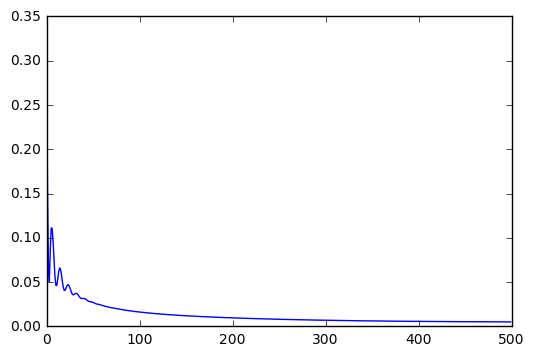

In [9]:
plt.plot(hist.history['loss'])

In [10]:
min(hist.history['loss'])

0.0051233065314590931